In [49]:
import torch 
import gym
import matplotlib
import matplotlib.pyplot as plt
import IPython
from collections import namedtuple, deque 
import random


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy
from itertools import count

In [50]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

Replay Memory

In [51]:
env = gym.make("CartPole-v1")
env.reset()

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

In [52]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemeory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # create an empty list with the length of capacity
    
    def push(self, *args): ## args accepts a tuple or list.
        self.memory.append(Transition(*args))
    
    def sample(self,batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Q-Network

In [53]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__() ## initalize the nn.Modul using the DQN
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        out1 = F.relu(self.layer1(x))
        out2 = F.relu(self.layer2(out1))
        return self.layer3(out2)

Training

In [54]:
BATCH_SIZE = 128 # the number of transitions sampled from the replay buffer
GAMMA = 0.99 # the discount fasctor as mentioned in the previous section
EPS_START = 0.9 # the starting value of epsilon
EPS_END = 0.05 # the final of the epsilon
EPS_DECAY = 1e3 # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 5e-3 # the update rate of the target network
LR = 1e-4 # leanring rate of the "AdamW" optimizer

In [55]:
n_actions = env.action_space.n #the length of the action
state, info = env.reset() # reset the game and get the state and info of the game
print(state, info)
n_observations = len(state) # the length of the state

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr = LR, amsgrad=True)
memory = ReplayMemeory(10000)

[ 0.01344743 -0.01596187  0.00775426  0.0195027 ] {}


In [56]:
step_done = 0
def select_action(state):
    global step_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START-EPS_END)*(math.exp(-1.*step_done/EPS_DECAY)) # epsilon-greedy algorithm. epsilon decreases as episode increases
    step_done += 1
    if sample > eps_threshold: # exploitation
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1) # transform the tensor into the shape (1,1)
    else: # exploration
        # return torch.tensor([[env.action_space()]], device=device, dtype=torch.long)
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [57]:
episode_durations = [] # it stores the duration of the each episode

def plot_durations(show_result=False):
    plt.figure(1) # plot on the figure 1
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Traning...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy()) # ocnvert durations_t from tensor to a numpy array
    if len(durations_t) >= 100: # compute the moving average of the 100 episodes
        means = durations_t.unfold(0, 100, 1).mean(1).reshape(-1) # var.unfold(dimension, size, step) can be used to create a moving window
        # mean(dimension) computes the mean across a specific dimension
        means = torch.cat((torch.zeros(99), means)) # to align it with the episode durations
        plt.plot(means.numpy())
    
    plt.pause(1e-3)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf()) # get current figure
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training Loop

In [58]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) # batch would be in the form: [tensor1, None, tensor2, None, tensor3,...]

    # create a boolean mask indicating which entries are not not "None". "None" usually mean the terminal state of the agent
    # if the entry in batch.next_state = None, it will return "False" in this position
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool) 
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # compute the Q(s_t, a). the model computes Q(s_t), then we select the columns of the actions taken.
    state_action_values = policy_net(state_batch).gather(1, action_batch) # gather(dim, index)

    # compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad(): # 
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(-1).values # only update the state which is not termial state
    
    expected_action_values = (next_state_values*GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_action_values)

    # optimize the model
    optimizer.zero_grad() #delete the gradients of the previous loop
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100) # clip the model-parameters within 100 to avoid explosion
    optimizer.step() # update the model using the computed parameters


Training

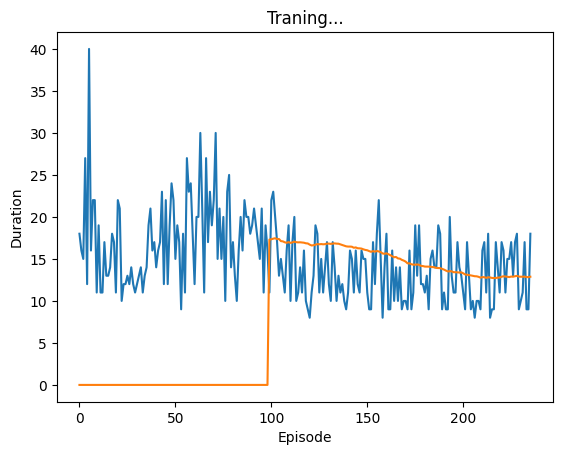

<Figure size 640x480 with 0 Axes>

In [59]:
if torch.cuda.is_available():
    num_epsisodes = 600
else:
    num_epsisodes = 50

for i_episode in range(num_epsisodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break


print("complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()
